In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from dynamical_systems.SIR_Identifiable import *
import matplotlib.pyplot as plt

### Solve SIR Identifiable Dynamics

In [2]:
x0 = np.array([900,100,0]) # initial condition
true_theta_dyn = np.array([0.02,0.6,0.15]) # True parameters
t_eval = np.linspace(0,6,61)

sol = solve_SIR_forward(true_theta_dyn, sir_dynamics_identifiable, t_eval, x0)

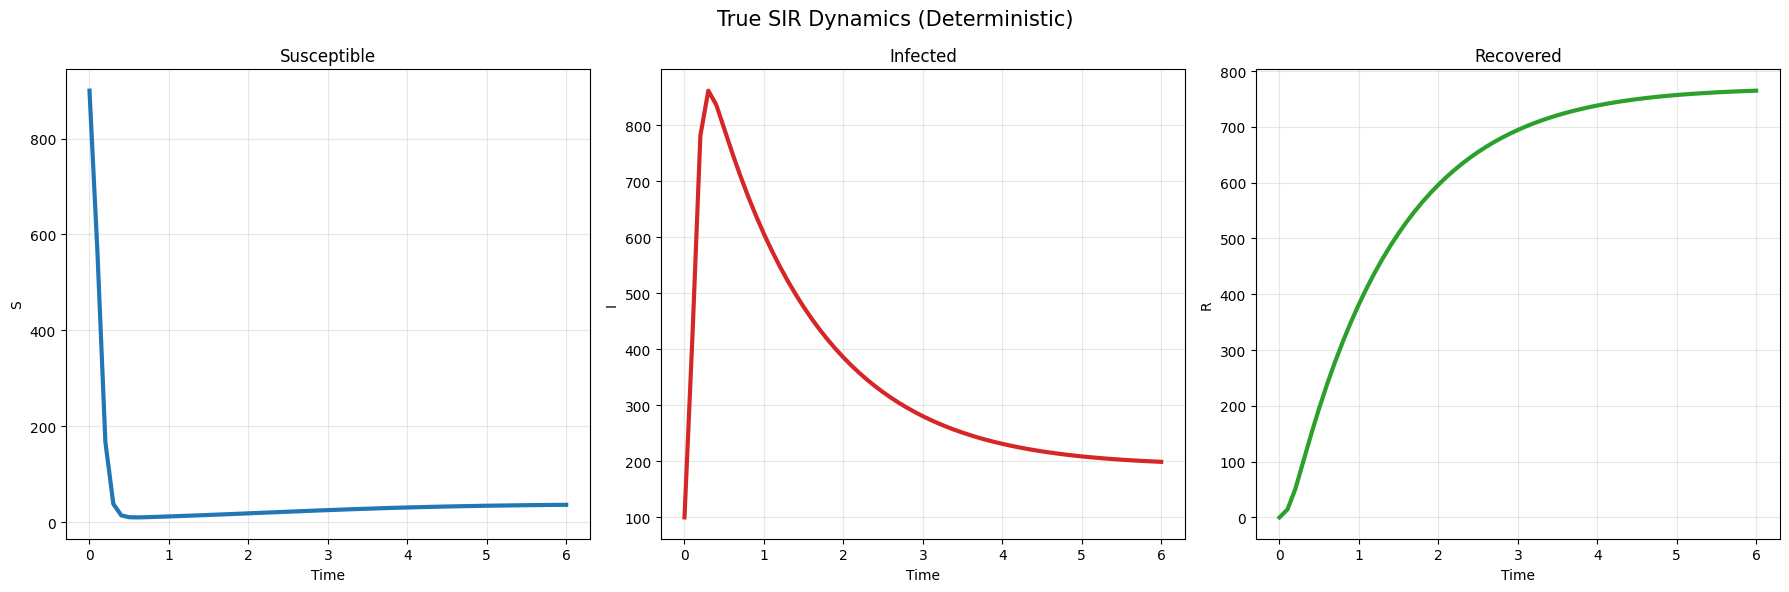

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

states = ['Susceptible', 'Infected', 'Recovered']
colors = ['tab:blue', 'tab:red', 'tab:green']
ylabels = ['S', 'I', 'R']

for i, ax in enumerate(axs):
    ax.plot(sol.t, sol.y[i], color=colors[i], lw=3)
    ax.set_title(states[i])
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('Time')
    ax.grid(alpha=0.3)

fig.suptitle('True SIR Dynamics (Deterministic)', fontsize=15)
plt.tight_layout()
plt.show()

## Generate Sensor Data

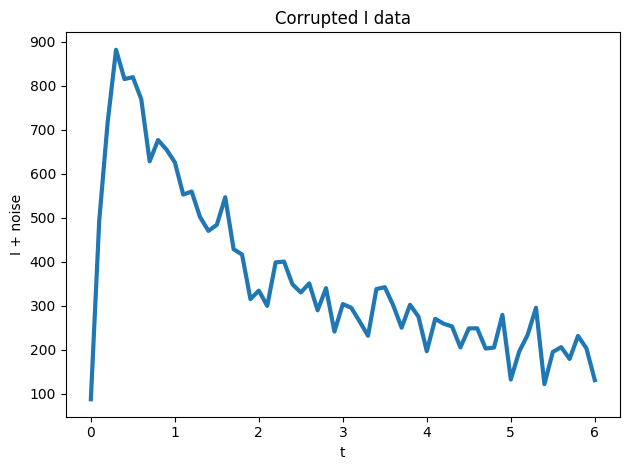

In [4]:
num_points = 61
process_std = 50
whitenoise = process_std*np.random.randn(num_points)
corrupted_I = sol.y[1] + whitenoise

plt.plot(sol.t, corrupted_I, linewidth=3.0)
plt.xlabel('t');plt.ylabel('I + noise')
plt.title("Corrupted I data")
plt.tight_layout()
plt.show()

# Laplace Approximation for SIR Identifiable

In [5]:
prior_mean = np.zeros(3)
prior_cov = np.identity(3)

logpost = lambda params: log_posterior_SIR(params, 
                                           corrupted_I, 
                                           process_std,
                                           t_eval, 
                                           sir_dynamics_identifiable, 
                                           prior_mean, 
                                           prior_cov)

guess = np.array([0,0,0]) # random guess
# guess = np.random.randn((3)) # random guess
map_point, cov_laplace = laplace_approx(guess, logpost)
print("map Point = ", map_point)
print("Laplace Covariance = \n" , cov_laplace)

map Point =  [0.02038683 0.60151119 0.16230726]
Laplace Covariance = 
 [[ 2.64830551e-06 -2.57258049e-06 -2.22750802e-06]
 [-2.57258049e-06  6.89093504e-04  4.06990178e-04]
 [-2.22750802e-06  4.06990178e-04  3.44949099e-04]]


## Apply DRAM for SIR Model

In [6]:
from mcmc.algorithms.dram import *
from mcmc.utils.mcmc_utils import *
from mcmc.diagnostics.autocorrelation import *
from mcmc.utils.run_helpers import *
from mcmc.diagnostics.iac_and_ess import *

In [7]:
target_logpdf = lambda x : log_posterior_SIR(x,
                                             corrupted_I,
                                             process_std,
                                             t_eval,
                                             sir_dynamics_identifiable,
                                             prior_mean,
                                             prior_cov)

val = target_logpdf(true_theta_dyn)
print(val, type(val), np.shape(val))

-24.27904124262728 <class 'numpy.float64'> ()


In [8]:
target_logpdf = lambda x : log_posterior_SIR(x,
                                             corrupted_I,
                                             process_std,
                                             t_eval,
                                             sir_dynamics_identifiable,
                                             prior_mean,
                                             prior_cov)

# initial conditions
initial_sample = map_point
initial_cov = cov_laplace # from Laplace Approximation
num_samples = 100000

# Proposal Distribution properties
proposal_logpdf = proposal_mvn_logpdf_eval
proposal_sampler = proposal_mvn_sampler

## Deyaled Rejection
dram_samples = dram_mcmc(initial_sample, initial_cov, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, k0=2000, freq_of_update=500, verbose=True)

samples = dram_samples.samples
print("Accepted Samples Ratio:", dram_samples.accept_rate)

Finished sample 1000, acceptance ratio = 0.807
Finished sample 2000, acceptance ratio = 0.799
Finished sample 3000, acceptance ratio = 0.768
Finished sample 4000, acceptance ratio = 0.748
Finished sample 5000, acceptance ratio = 0.739
Finished sample 6000, acceptance ratio = 0.728
Finished sample 7000, acceptance ratio = 0.722
Finished sample 8000, acceptance ratio = 0.715
Finished sample 9000, acceptance ratio = 0.711
Finished sample 10000, acceptance ratio = 0.707
Finished sample 11000, acceptance ratio = 0.704
Finished sample 12000, acceptance ratio = 0.701
Finished sample 13000, acceptance ratio = 0.699
Finished sample 14000, acceptance ratio = 0.695
Finished sample 15000, acceptance ratio = 0.694
Finished sample 16000, acceptance ratio = 0.692
Finished sample 17000, acceptance ratio = 0.690
Finished sample 18000, acceptance ratio = 0.689
Finished sample 19000, acceptance ratio = 0.688
Finished sample 20000, acceptance ratio = 0.685
Finished sample 21000, acceptance ratio = 0.683
F

In [9]:
new_mh_result= mcmc_burnin_and_thin(dram_samples, burnin_frac=0.2, thin_frac=1)
samples = new_mh_result.samples
print("Accepted Samples Ratio:", new_mh_result.accept_rate)

Accepted Samples Ratio: 0.6531375


In [10]:
print(np.sum(samples, axis=0)/samples.shape[0])

[0.02104042 0.60749282 0.16613647]


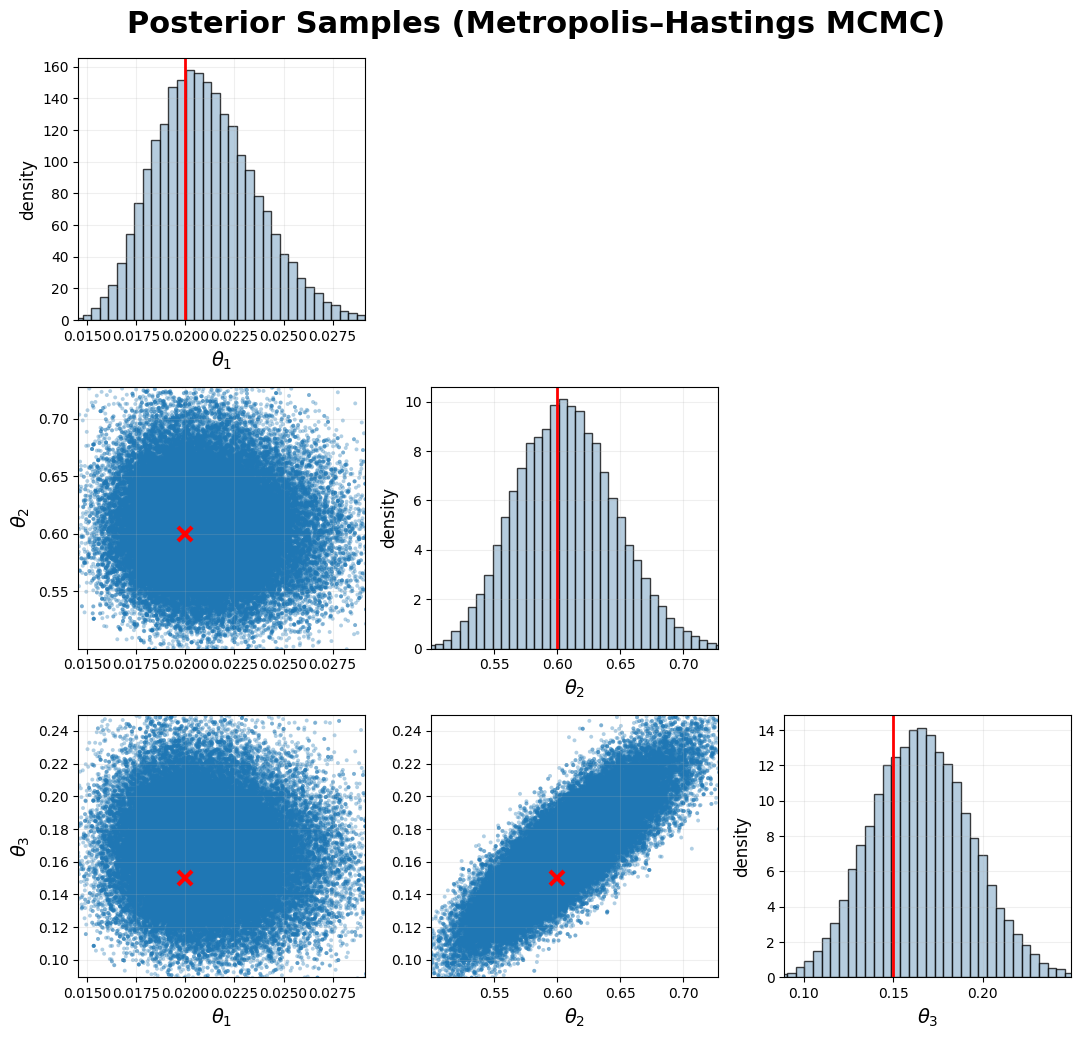

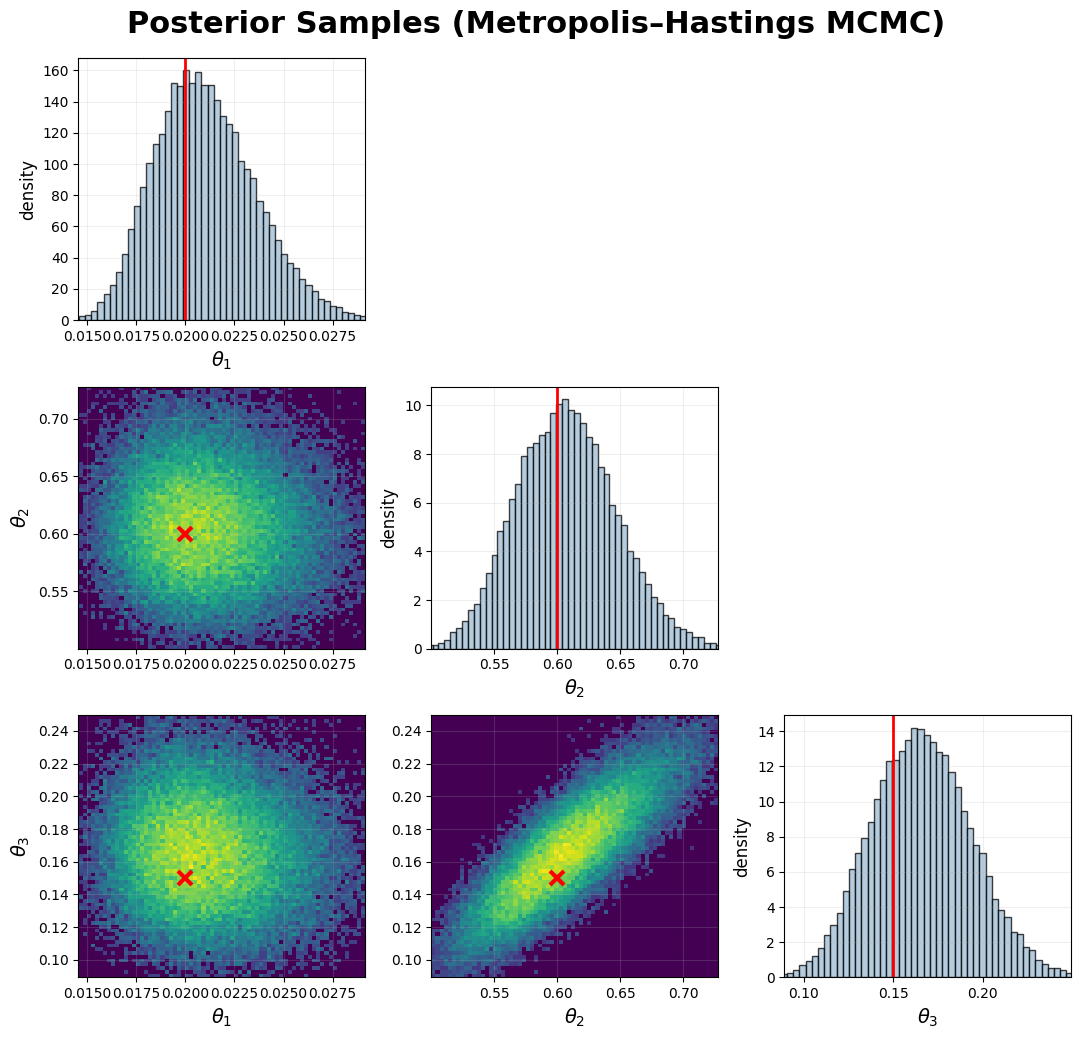

In [11]:
plt.close()
fig, axs, gs = scatter_matrix_clean(
    11,
    [samples],
    truths=true_theta_dyn,          # or None
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    hist_plot=False,
)
plt.show()

plt.close(12)
fig, axs, gs = scatter_matrix_clean(
    12,
    [samples],
    truths=true_theta_dyn,
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    hist_plot=True,
    nbins=70
)
plt.show()

Text(0.5, 0.98, 'SIR Identifiable DRAM Mixing')

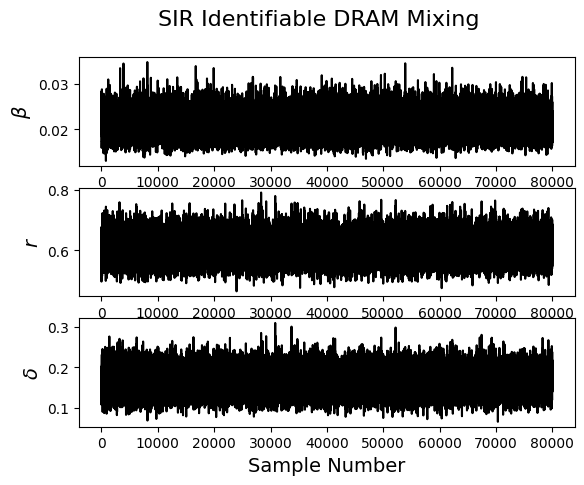

In [12]:
plt.close(4)
fig, axs = plt.subplots(3, 1, num=4)
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$\beta$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$r$', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$\delta$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)
fig.suptitle('SIR Identifiable DRAM Mixing', fontsize=16)

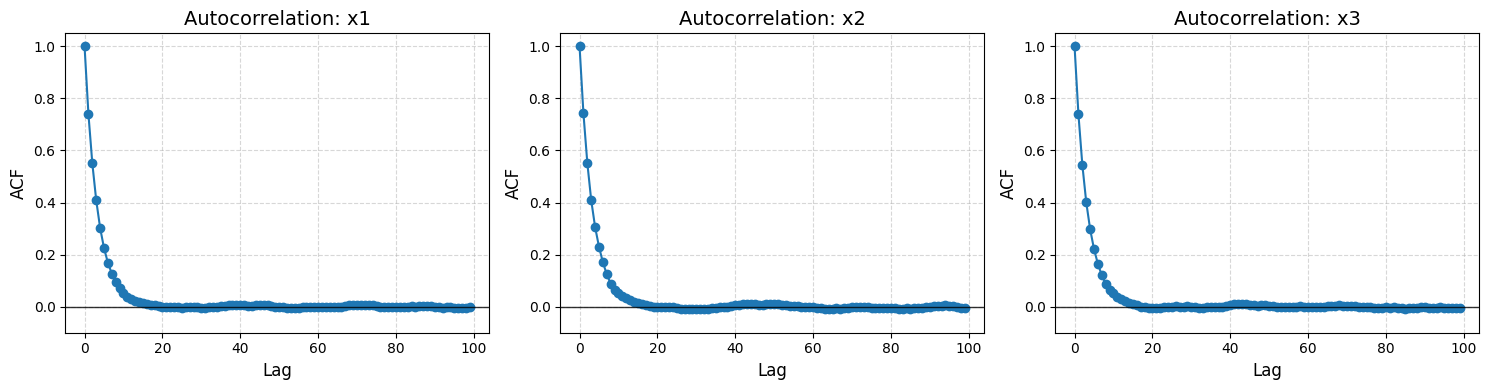

In [13]:
lags, acf = autocorrelation_vectorized(samples, max_lag=100)
plot_autocorrelation_3d(lags, acf, dim_names=("x1", "x2", "x3"))

In [14]:
iac, acf, lags = integrated_autocorrelation(samples, max_lag=300)
ess = effective_sample_size(samples, iac)

N = samples.shape[0]
efficiency = ess / N * 100  # percentage

print(f"Total samples: {N}\n")

for k in range(len(iac)):
    print(f"Dimension {k}:")
    print(f"  IAC:          {iac[k]:.4f}")
    print(f"  ESS:          {ess[k]:.2f}")
    print(f"  Efficiency:   {efficiency[k]:.1f}%   "
          f"({efficiency[k]:.1f}% as effective as independent samples)")
    print()

Total samples: 80000

Dimension 0:
  IAC:          6.7816
  ESS:          11796.68
  Efficiency:   14.7%   (14.7% as effective as independent samples)

Dimension 1:
  IAC:          6.7759
  ESS:          11806.55
  Efficiency:   14.8%   (14.8% as effective as independent samples)

Dimension 2:
  IAC:          6.6341
  ESS:          12058.98
  Efficiency:   15.1%   (15.1% as effective as independent samples)



## Prior predictive Dynamics 

[-0.29453072 -0.17090254  0.5909193 ]
0
[ 1.21508532  0.6676864  -0.49811829]
[-1.88058881 -0.99604391 -0.86160368]
[ 1.00914949 -0.35000482  0.3582041 ]
[ 0.73996425 -0.08493495 -1.13870441]
[-0.47436324 -1.69835602  0.52963734]
[0.49827785 0.30158739 1.3636348 ]
[-0.51775106 -0.74655792 -0.43910247]
[-1.12297411 -0.26898705  0.61091158]
[ 0.71076571 -0.45417875  0.07779591]
[ 0.45431457 -0.12516358  0.04228227]
10
[-0.80724038 -0.35681134  0.4541511 ]
[-0.37306425 -0.08955153 -0.39553765]
[ 2.30797987  2.45477654 -0.18674769]
[2.04629638 0.75661819 0.00810687]
for Loop Done


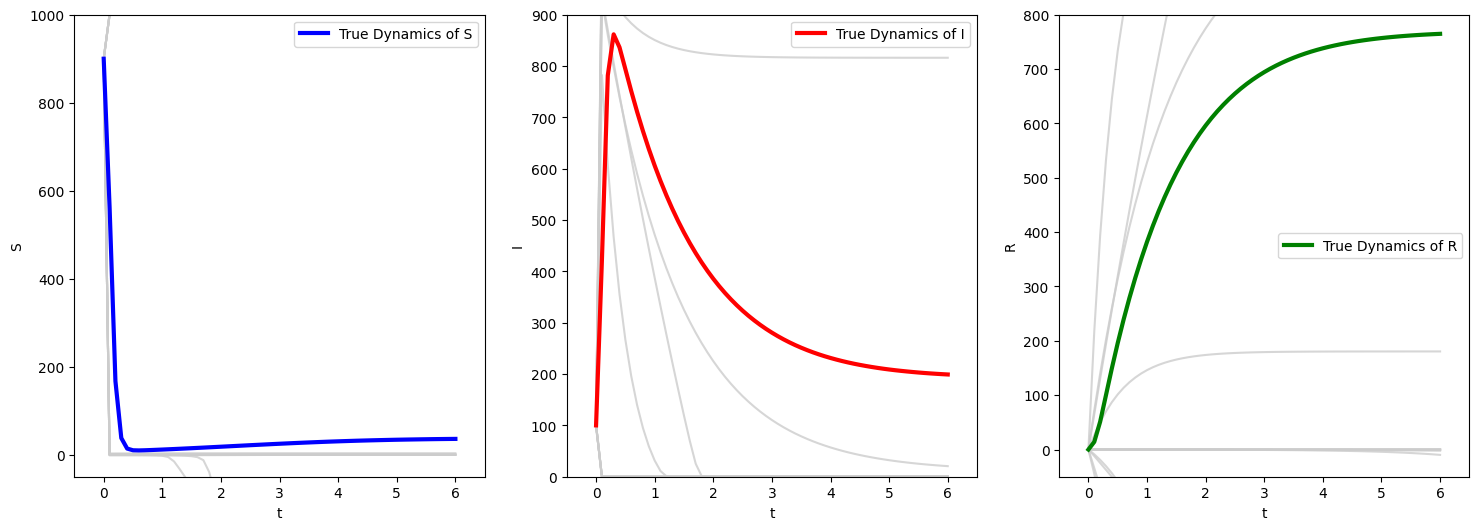

In [49]:
# Given
x0 = np.array([900,100,0]) # initial condition
true_theta_dyn = np.array([0.02,0.6,0.15]) # True parameters
t_eval = np.linspace(0,6,61)

# Prior information
prior_mean = np.zeros(3)
prior_cov = np.identity(3)
num_traj = 15

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.set_xlabel('t');ax1.set_ylabel('S')
ax2.set_xlabel('t');ax2.set_ylabel('I')
ax3.set_xlabel('t');ax3.set_ylabel('R')
ax1.set_xlim(-0.5,6.5);ax1.set_ylim(-50,1000)
ax2.set_xlim(-0.5,6.5);ax2.set_ylim(0,900)
ax3.set_xlim(-0.5,6.5);ax3.set_ylim(-50,800)

for i in range(num_traj):
    theta_params = proposal_mvn_sampler(prior_mean,prior_cov)
    print(theta_params)
    sol = solve_SIR_forward(theta_params, sir_dynamics_identifiable, t_eval, x0)
    
    ax1.plot(sol.t, sol.y[0],color='0.8', alpha=0.8)
    ax2.plot(sol.t, sol.y[1],color='0.8', alpha=0.8)
    ax3.plot(sol.t, sol.y[2],color='0.8', alpha=0.8)
    
    if (i % 10) == 0:
        print(i)
    

sol = solve_SIR_forward(true_theta_dyn, sir_dynamics_identifiable, t_eval, x0)
ax1.plot(sol.t, sol.y[0], linewidth=3.0, label="True Dynamics of S", color="blue")
ax2.plot(sol.t, sol.y[1], linewidth=3.0, label="True Dynamics of I", color="red")
ax3.plot(sol.t, sol.y[2], linewidth=3.0, label="True Dynamics of R", color='green')
ax1.legend()
ax2.legend()
ax3.legend()
print("for Loop Done")

## Posterior Predictive Dynamics

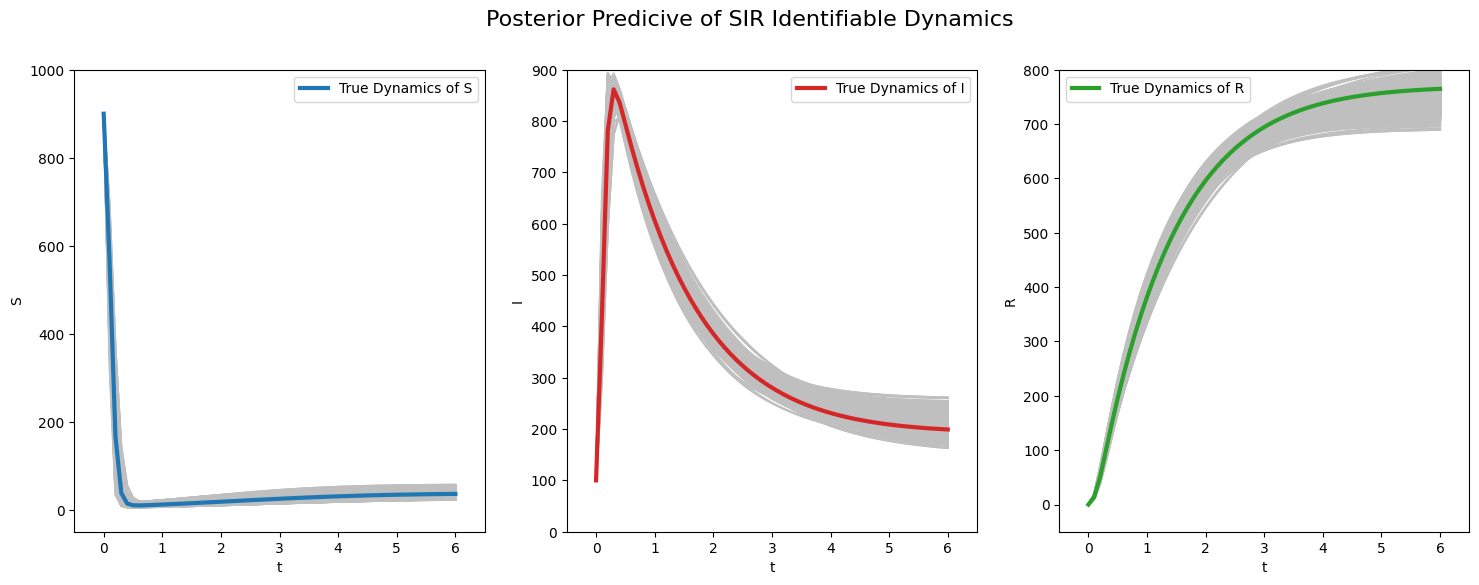

In [61]:
# Given
x0 = np.array([900,100,0]) # initial condition
true_theta_dyn = np.array([0.02,0.6,0.15]) # True parameters
t_eval = np.linspace(0,6,61)

num_traj = 1000

posteriorData = samples[-num_traj:, :]

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.set_xlabel('t');ax1.set_ylabel('S')
ax2.set_xlabel('t');ax2.set_ylabel('I')
ax3.set_xlabel('t');ax3.set_ylabel('R')
ax1.set_xlim(-0.5,6.5);ax1.set_ylim(-50,1000)
ax2.set_xlim(-0.5,6.5);ax2.set_ylim(0,900)
ax3.set_xlim(-0.5,6.5);ax3.set_ylim(-50,800)

for i in range(num_traj):
    posterior_params = posteriorData[i,:]
    sol = solve_SIR_forward(posterior_params, sir_dynamics_identifiable, t_eval, x0)
    
    ax1.plot(sol.t, sol.y[0],color="0.75", alpha=1.0)
    ax2.plot(sol.t, sol.y[1],color="0.75", alpha=1.0)
    ax3.plot(sol.t, sol.y[2],color="0.75", alpha=1.0)
        
params = np.array([0.02,0.6,0.15])
sol = solve_SIR_forward(true_theta_dyn, sir_dynamics_identifiable, t_eval, x0)
ax1.plot(sol.t, sol.y[0], linewidth=3.0, label="True Dynamics of S", color="tab:blue")
ax2.plot(sol.t, sol.y[1], linewidth=3.0, label="True Dynamics of I", color="tab:red")
ax3.plot(sol.t, sol.y[2], linewidth=3.0, label="True Dynamics of R", color='tab:green')

ax1.legend()
ax2.legend()
ax3.legend()
fig.suptitle('Posterior Predicive of SIR Identifiable Dynamics', fontsize=16)
# plt.savefig("Images/2b_Posterior_Pred_SIR_Identifiable.png")
plt.show()
    